In [50]:
import geopandas as gpd 
import pandas as pd
import osmnx
import contextily as cx 
import matplotlib.pyplot as plt 
from pyproj import CRS
import seaborn as sns
import numpy as np
from dateutil.parser import parse

import helper

In [76]:
df = pd.read_csv('data/monthly/24_03.csv')

gdf_stations = helper.create_stations_gdf(df)
gdf_rides = helper.create_rides_gdf(df)

/Users/niclasclassen/Code/Master/geospatial-ds-exam/helper.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rides["geometry"] = df_rides.apply(


## Distribution of how long people rent a bike

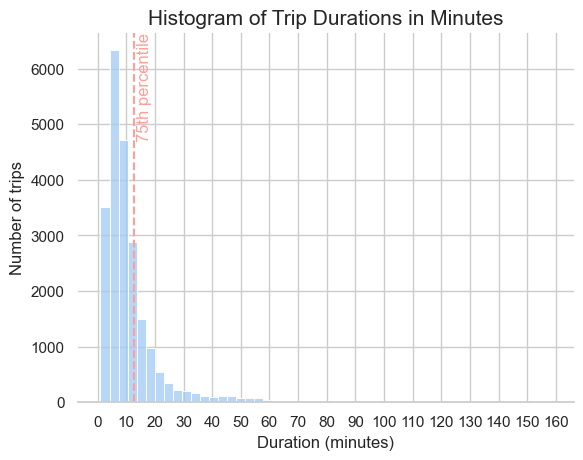

In [81]:
gdf_rides['duration_in_minutes'] = gdf_rides['duration'] / 60

# Calculate percentiles
percentiles = np.percentile(gdf_rides['duration_in_minutes'], [75])

# Set the style and color palette of the plot
sns.set_color_codes('pastel')

# Create a histogram of the duration in minutes
sns.histplot(gdf_rides['duration_in_minutes'], bins=50, color='b')

# Add vertical lines for the percentiles
for percentile in percentiles:
    plt.axvline(x=percentile, color='r', linestyle='--')
    plt.text(percentile+1, plt.gca().get_ylim()[1], '75th percentile', color='r', rotation=90, verticalalignment='top')

# Set the title and labels of the plot
plt.title('Histogram of Trip Durations in Minutes', fontsize=15)
plt.xlabel('Duration (minutes)', fontsize=12)
plt.ylabel('Number of trips', fontsize=12)

# Set x-axis labels to increments of 10
plt.xticks(np.arange(0, max(gdf_rides['duration_in_minutes'])+10, 10))

# Remove the top, right, and left spines from plot
sns.despine(left=True)

# Show the plot
plt.show()

## Number of trips during a day (start time)

In [47]:
print(gdf_rides['started_at'][1125])
print(gdf_rides['started_at'][1124])
print(gdf_rides['started_at'][1123])
print(gdf_rides['started_at'][1121])

2024-03-03 19:15:46+00:00
2024-03-03 19:13:06.702000+00:00
2024-03-03 19:13:03.774000+00:00
2024-03-03 19:12:40.249000+00:00


In [82]:
def custom_date_parser(d):
    return parse(d)

In [85]:
# Convert 'started_at' to datetime format
gdf_rides['started_at_converted'] = gdf_rides['started_at'].apply(custom_date_parser)

# Extract the hour and the day of the week
gdf_rides['day'] = gdf_rides['started_at_converted'].dt.day
gdf_rides['hour'] = gdf_rides['started_at_converted'].dt.hour
gdf_rides['day_of_week'] = gdf_rides['started_at_converted'].dt.dayofweek
gdf_rides['weekday_or_weekend'] = gdf_rides['day_of_week'].apply(lambda x: 'Weekday' if x < 5 else 'Weekend')

bins = list(range(0, 25, 1))  # Create bins for each hour
labels = [f'{i}-{i+1}' for i in bins[:-1]]  # Create labels for each bin
gdf_rides['hour_interval'] = pd.cut(gdf_rides['hour'], bins=bins, labels=labels, right=False)

/var/folders/sh/fjb1r_5j6gxcy4lzfcc4_4zr0000gn/T/ipykernel_97849/1400126263.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = gdf_rides.groupby(['day', 'hour_interval', 'weekday_or_weekend']).size().reset_index(name='num_trips')


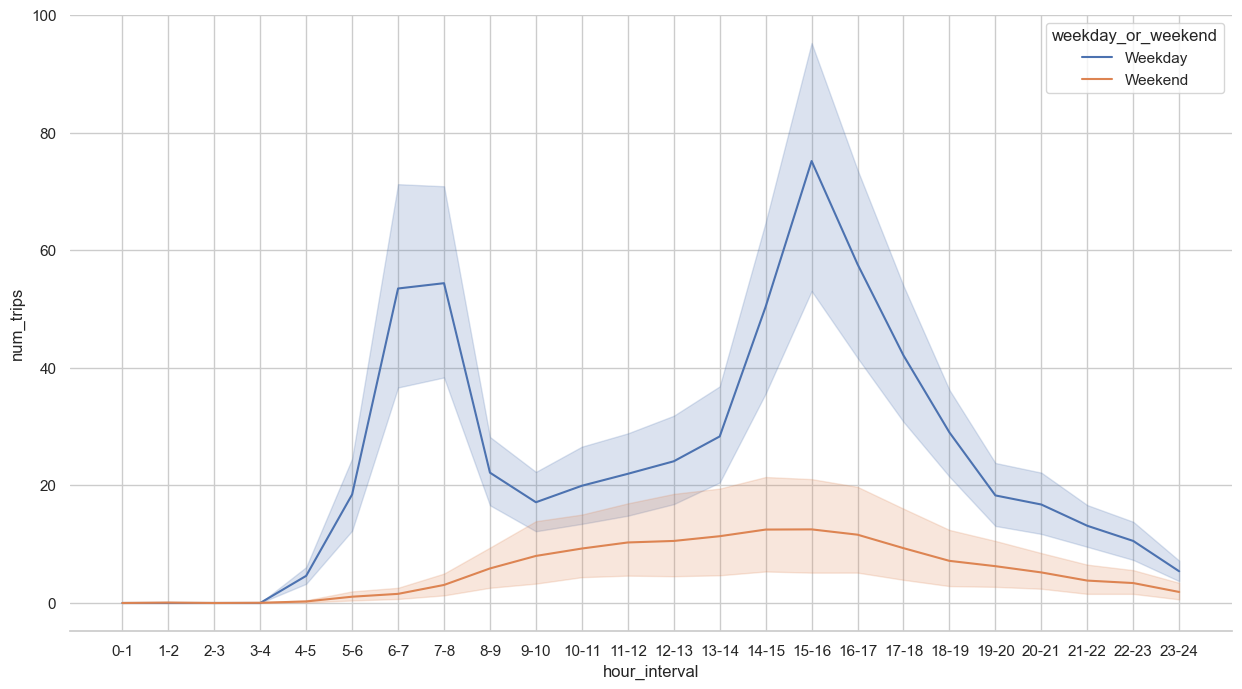

In [86]:
# Group by 'day', 'hour_interval', and 'weekday_or_weekend' and count the number of trips
grouped = gdf_rides.groupby(['day', 'hour_interval', 'weekday_or_weekend']).size().reset_index(name='num_trips')

# Create the lineplot
plt.figure(figsize=(15, 8))
sns.lineplot(data=grouped, x='hour_interval', y='num_trips', hue='weekday_or_weekend')

# Remove the top, right, and left spines from plot
sns.despine(left=True)

plt.show()

## Trip duration by weekday

/var/folders/sh/fjb1r_5j6gxcy4lzfcc4_4zr0000gn/T/ipykernel_97849/4225409305.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=gdf_rides, y='weekday', x='duration_in_minutes', ci=None, color='b', orient='h')


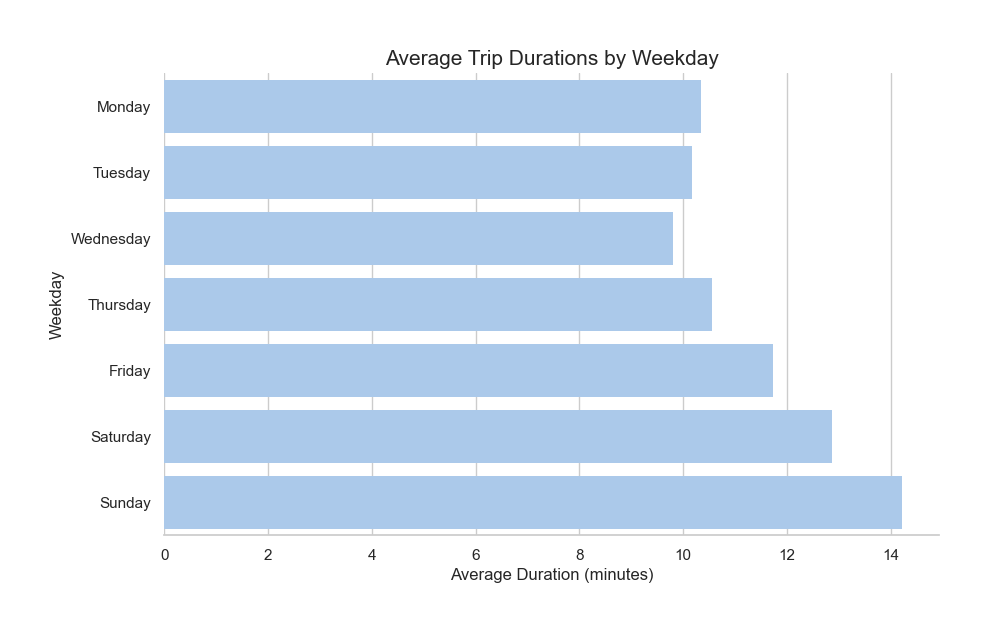

In [115]:
# Define the order of the days
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

gdf_rides['weekday'] = pd.Categorical(gdf_rides['weekday'], categories=days, ordered=True)

# Create the barplot with switched axes
plt.figure(figsize=(10, 6))
sns.barplot(data=gdf_rides, y='weekday', x='duration_in_minutes', ci=None, color='b', orient='h')

# Set the title and labels of the plot
plt.title('Average Trip Durations by Weekday', fontsize=15)
plt.ylabel('Weekday', fontsize=12)
plt.xlabel('Average Duration (minutes)', fontsize=12)

# Remove the top, right, and left spines from plot
sns.despine(left=True)

# Show the plot
plt.show()

## Chord map of rides

In [181]:
gdf_rides.head(5)

,start_station_id,end_station_id,started_at,ended_at,duration,start_station_name,start_station_description,start_station_latitude,start_station_longitude,end_station_name,...,end_station_longitude,geometry,duration_in_minutes,started_at_converted,day,day_of_week,weekday_or_weekend,hour,hour_interval,weekday
0,615,452,2024-03-01 04:34:34.497000+00:00,2024-03-01 04:39:41.953000+00:00,307,Munkedamsveien,ved Haakon VIIs gate,59.913523,10.730106,Vippetangen vest,...,10.740627,"LINESTRING (10.73011 59.91352, 10.74063 59.90399)",5.116667,2024-03-01 04:34:34.497000+00:00,1,4,Weekday,4,4-5,Friday
1,444,526,2024-03-01 04:41:02.793000+00:00,2024-03-01 04:47:58.198000+00:00,415,AHO,langs Maridalsveien,59.925265,10.750462,Lille Grensen,...,10.742310,"LINESTRING (10.75046 59.92527, 10.74231 59.91390)",6.916667,2024-03-01 04:41:02.793000+00:00,1,4,Weekday,4,4-5,Friday
2,392,464,2024-03-01 04:45:50.903000+00:00,2024-03-01 04:52:54.592000+00:00,423,Sjøsiden 2 ved fontenen,to rader nærmest fontenen,59.910181,10.751699,Sukkerbiten,...,10.753764,"LINESTRING (10.75170 59.91018, 10.75376 59.90512)",7.050000,2024-03-01 04:45:50.903000+00:00,1,4,Weekday,4,4-5,Friday
3,564,396,2024-03-01 04:46:58.214000+00:00,2024-03-01 04:53:27.653000+00:00,389,Oscars gate,ved Hegdehaugsveien,59.922422,10.727239,Kirkeristen,...,10.746761,"LINESTRING (10.72724 59.92242, 10.74676 59.91300)",6.483333,2024-03-01 04:46:58.214000+00:00,1,4,Weekday,4,4-5,Friday
4,421,448,2024-03-01 04:56:09.969000+00:00,2024-03-01 05:04:30.171000+00:00,500,Alexander Kiellands Plass,langs Maridalsveien,59.928067,10.751203,Oslo Plaza,...,10.754434,"LINESTRING (10.75120 59.92807, 10.75443 59.91218)",8.333333,2024-03-01 04:56:09.969000+00:00,1,4,Weekday,4,4-5,Friday


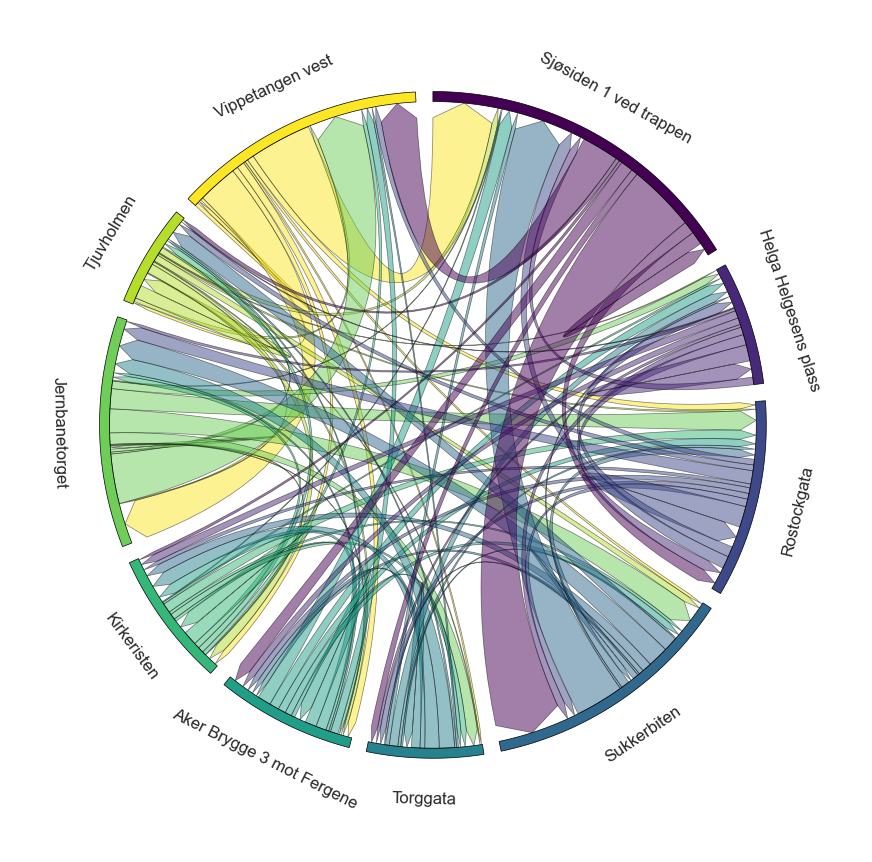

In [270]:
from pycirclize import Circos
from pycirclize.utils import calc_group_spaces, ColorCycler

# Concatenate start_station_name and end_station_name
stations = pd.concat([gdf_rides['start_station_name'], gdf_rides['end_station_name']])

# Get top 5 stations with most rides
top_stations = stations.value_counts().head(10)
filtered_gdf_rides = gdf_rides[gdf_rides['start_station_name'].isin(top_stations.index) & gdf_rides['end_station_name'].isin(top_stations.index)]

# Create from-to table dataframe & convert to matrix
from_to_table = filtered_gdf_rides.groupby(['start_station_name', 'end_station_name']).size().unstack().fillna(0)

matrix_df = pd.DataFrame(from_to_table, index=top_stations.index, columns=top_stations.index)

circos = Circos.initialize_from_matrix(
    matrix_df,
    space=3,
    cmap="viridis",
    label_kws=dict(size=12, r=110),
    link_kws=dict(direction=1, ec="black", lw=0.5),
)
fig = circos.plotfig()

/Users/niclasclassen/Code/Master/geospatial-ds-exam/.venv/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


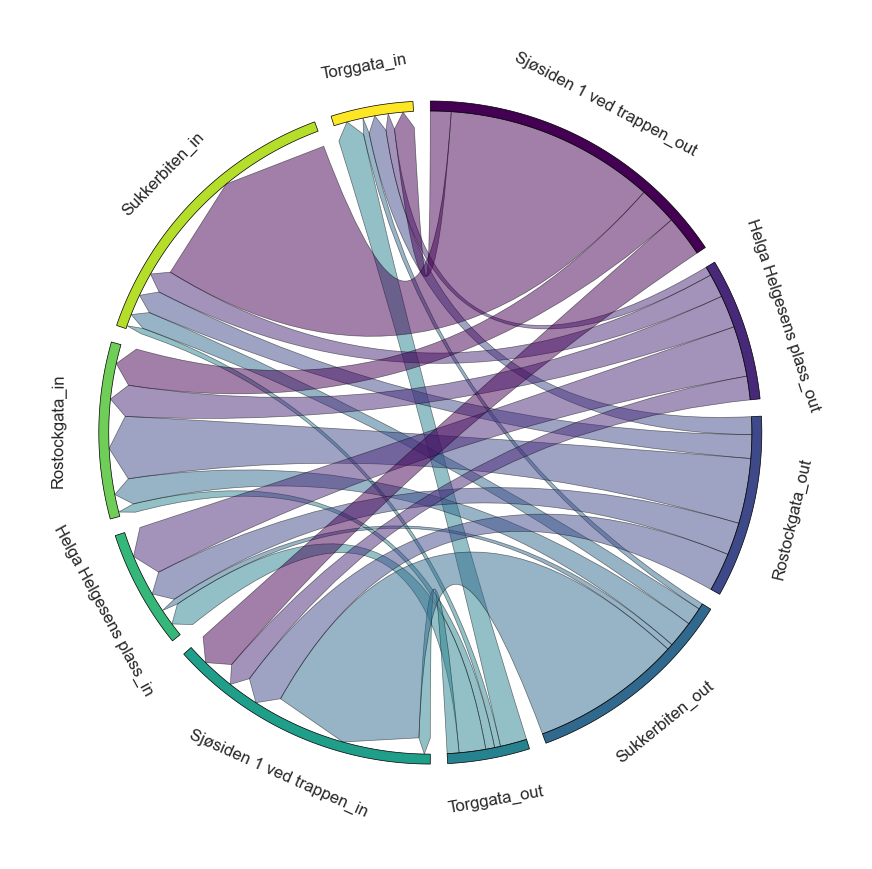

In [267]:
from pycirclize import Circos
from pycirclize.utils import calc_group_spaces, ColorCycler

# Concatenate start_station_name and end_station_name
stations = pd.concat([gdf_rides['start_station_name'], gdf_rides['end_station_name']])

# Get top 5 stations with most rides
top_stations = stations.value_counts().head(5)
filtered_gdf_rides = gdf_rides[gdf_rides['start_station_name'].isin(top_stations.index) & gdf_rides['end_station_name'].isin(top_stations.index)]

# Append '_in' and '_out' to 'start_station_name' and 'end_station_name' respectively
filtered_gdf_rides['start_station_name'] = filtered_gdf_rides['start_station_name'].apply(lambda x: f"{x}_out")
filtered_gdf_rides['end_station_name'] = filtered_gdf_rides['end_station_name'].apply(lambda x: f"{x}_in")


# Create from-to table dataframe & convert to matrix
from_to_table = filtered_gdf_rides.groupby(['start_station_name', 'end_station_name']).size().unstack().fillna(0)

matrix_df = pd.DataFrame(from_to_table, index=[f"{station}_out" for station in top_stations.index], columns=[f"{station}_in" for station in top_stations.index])

circos = Circos.initialize_from_matrix(
    matrix_df,
    space=3,
    cmap="viridis",
    label_kws=dict(size=12, r=110),
    link_kws=dict(direction=1, ec="black", lw=0.5),
)
fig = circos.plotfig()

In [265]:
matrix_df

,Sjøsiden 1 ved trappen_in,Helga Helgesens plass_in,Rostockgata_in,Sukkerbiten_in,Torggata_in
Sjøsiden 1 ved trappen_out,14.0,0.0,13.0,71.0,7.0
Helga Helgesens plass_out,8.0,17.0,11.0,8.0,3.0
Rostockgata_out,13.0,11.0,22.0,8.0,6.0
Sukkerbiten_out,51.0,2.0,9.0,6.0,2.0
Torggata_out,4.0,9.0,3.0,2.0,9.0


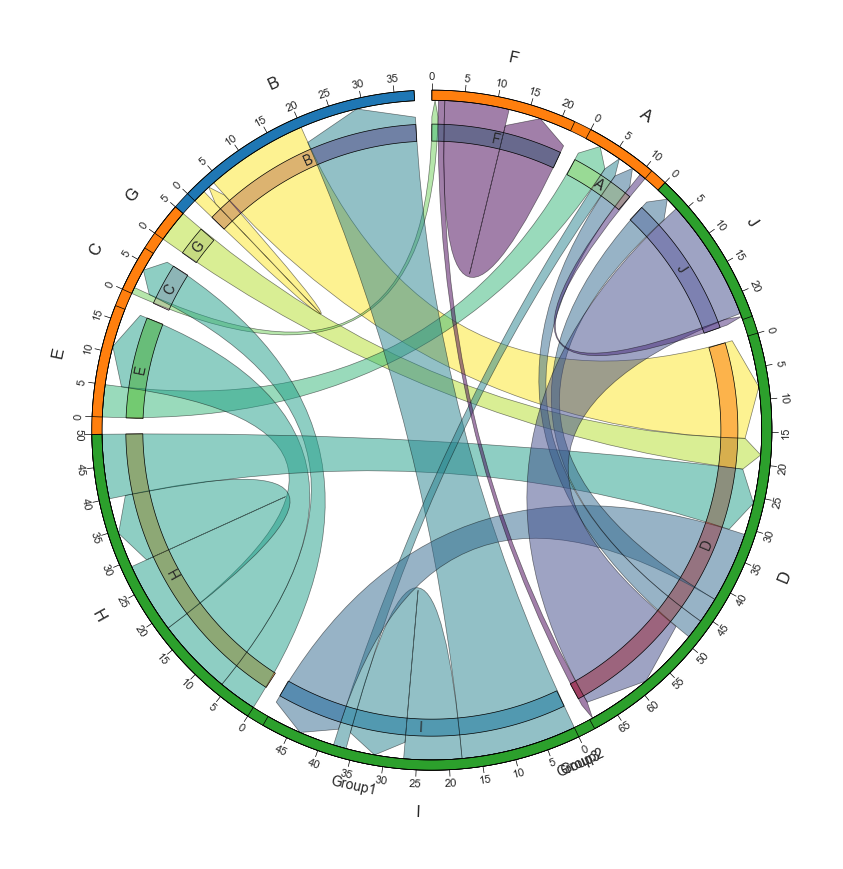

In [248]:
import numpy as np
import pandas as pd
from pycirclize.parser import Matrix

# Create a random from-to table
np.random.seed(0)  # for reproducibility
sectors_list = list(sectors.keys())
fromto_table_df = pd.DataFrame({
    'from': np.random.choice(sectors_list, size=20),
    'to': np.random.choice(sectors_list, size=20),
    'value': np.random.randint(1, 20, size=20)
})

# Convert the from-to table to a matrix
matrix = Matrix.parse_fromto_table(fromto_table_df)

# Initialize the Circos plot from the matrix
circos = Circos.initialize_from_matrix(
    matrix,
    space=3,
    cmap="viridis",
    ticks_interval=5,
    label_kws=dict(size=12, r=110),
    link_kws=dict(direction=1, ec="black", lw=0.5),
)

# Plot sector track
ColorCycler.set_cmap("Set3")
for sector in circos.sectors:
    track = sector.add_track(r_lim=(85, 90))
    track.axis(fc=ColorCycler())
    track.text(sector.name)

# Plot group sectors range
ColorCycler.set_cmap("tab10")
for idx, group in enumerate((group1, group2, group3), 1):
    group_deg_lim = circos.get_group_sectors_deg_lim(group)
    circos.rect(r_lim=(97, 100), deg_lim=group_deg_lim, fc=ColorCycler(), ec="black", lw=0.5)
    group_center_deg = sum(group_deg_lim) / 2
    circos.text(f"Group{idx}", r=105, deg=group_center_deg, adjust_rotation=True)

fig = circos.plotfig()

/Users/niclasclassen/Code/Master/geospatial-ds-exam/.venv/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


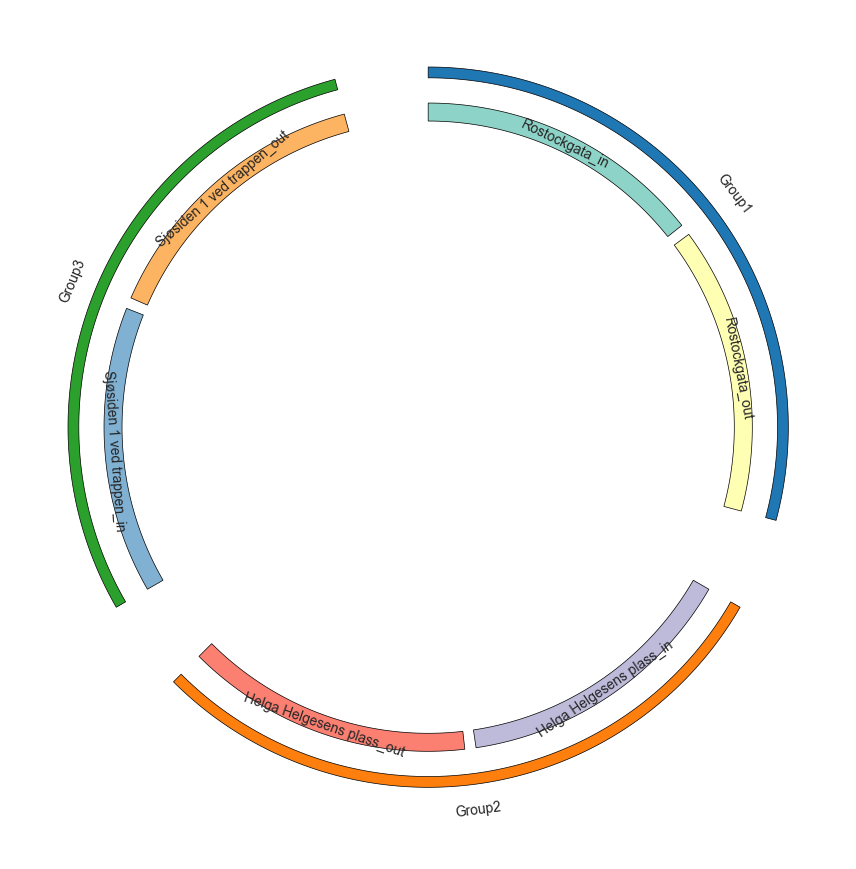

In [245]:
from pycirclize import Circos
from pycirclize.utils import calc_group_spaces, ColorCycler

# Concatenate start_station_name and end_station_name
stations = pd.concat([gdf_rides['start_station_name'], gdf_rides['end_station_name']])

# Get top 5 stations with most rides
top_stations = stations.value_counts().head(3)

# Filter the rides dataframe to only include the top 5 stations
filtered_gdf_rides = gdf_rides[gdf_rides['start_station_name'].isin(top_stations.index) & gdf_rides['end_station_name'].isin(top_stations.index)]

# Create sectors for each station
stations = filtered_gdf_rides['start_station_name'].unique()
sectors = {f"{station}_{direction}": 6 for station in stations for direction in ['in', 'out']}
# Create groups for each station
group1, group2, group3 = ["Rostockgata_in", "Rostockgata_out"], ['Helga Helgesens plass_in', 'Helga Helgesens plass_out'], ["Sjøsiden 1 ved trappen_in", "Sjøsiden 1 ved trappen_out"]

# Calculate appropriate group between/within spaces
spaces = calc_group_spaces([2, 2, 2], space_bw_group=15, space_in_group=2)

# Append '_in' and '_out' to 'start_station_name' and 'end_station_name' respectively
filtered_gdf_rides['start_station_name'] = filtered_gdf_rides['start_station_name'].apply(lambda x: f"{x}_out")
filtered_gdf_rides['end_station_name'] = filtered_gdf_rides['end_station_name'].apply(lambda x: f"{x}_in")

circos = Circos(sectors, space=spaces)

# Plot sector track
ColorCycler.set_cmap("Set3")
for sector in circos.sectors:
    track = sector.add_track(r_lim=(85, 90))
    track.axis(fc=ColorCycler())
    track.text(sector.name)

# Plot group sectors range
ColorCycler.set_cmap("tab10")
for idx, group in enumerate((group1, group2, group3), 1):
    group_deg_lim = circos.get_group_sectors_deg_lim(group)
    circos.rect(r_lim=(97, 100), deg_lim=group_deg_lim, fc=ColorCycler(), ec="black", lw=0.5)
    group_center_deg = sum(group_deg_lim) / 2
    circos.text(f"Group{idx}", r=105, deg=group_center_deg, adjust_rotation=True)

fig = circos.plotfig()

/Users/niclasclassen/Code/Master/geospatial-ds-exam/.venv/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


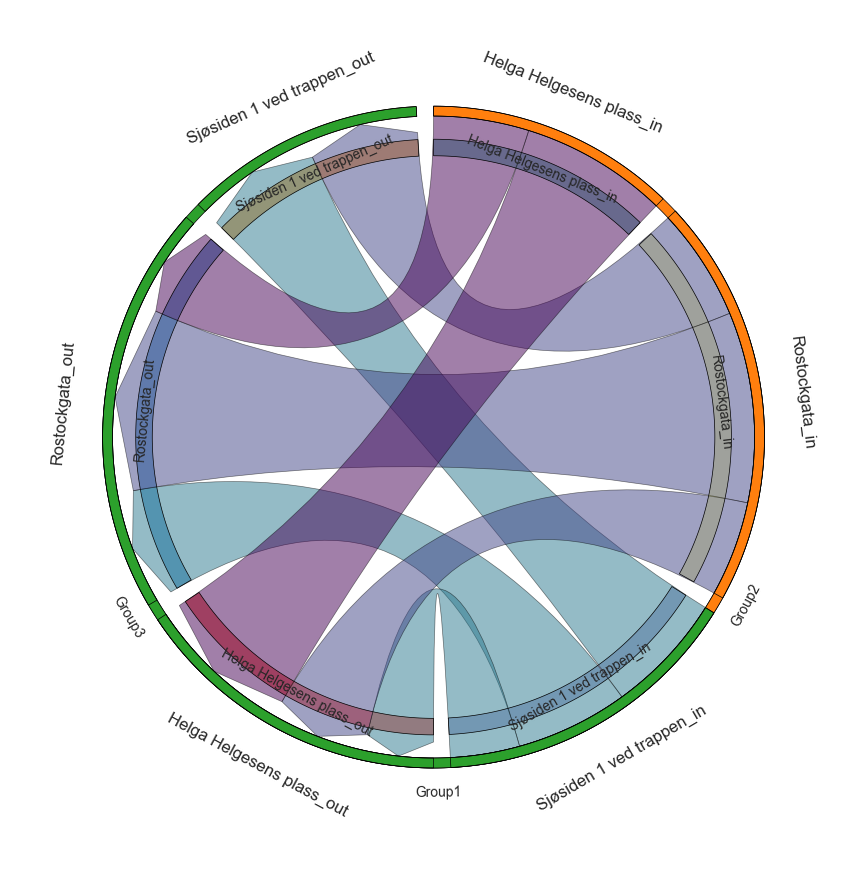

In [244]:
from pycirclize import Circos
from pycirclize.utils import calc_group_spaces, ColorCycler

# Concatenate start_station_name and end_station_name
stations = pd.concat([gdf_rides['start_station_name'], gdf_rides['end_station_name']])

# Get top 5 stations with most rides
top_stations = stations.value_counts().head(3)

# Filter the rides dataframe to only include the top 5 stations
filtered_gdf_rides = gdf_rides[gdf_rides['start_station_name'].isin(top_stations.index) & gdf_rides['end_station_name'].isin(top_stations.index)]

# Create sectors for each station
stations = filtered_gdf_rides['start_station_name'].unique()
sectors = {f"{station}_{direction}": 6 for station in stations for direction in ['in', 'out']}
# Create groups for each station
group1, group2, group3 = ["Rostockgata_in", "Rostockgata_out"], ['Helga Helgesens plass_in', 'Helga Helgesens plass_out'], ["Sjøsiden 1 ved trappen_in", "Sjøsiden 1 ved trappen_out"]

# Calculate appropriate group between/within spaces
spaces = calc_group_spaces([2, 2, 2], space_bw_group=15, space_in_group=2)


# Append '_in' and '_out' to 'start_station_name' and 'end_station_name' respectively
filtered_gdf_rides['start_station_name'] = filtered_gdf_rides['start_station_name'].apply(lambda x: f"{x}_out")
filtered_gdf_rides['end_station_name'] = filtered_gdf_rides['end_station_name'].apply(lambda x: f"{x}_in")

# Create from-to table dataframe & convert to matrix
from_to_table = filtered_gdf_rides.groupby(['start_station_name', 'end_station_name']).size().unstack().fillna(0)
# Append '_in' to index and '_out' to columns
matrix_df = filtered_gdf_rides.pivot_table(index='end_station_name', columns='start_station_name', aggfunc='size', fill_value=0)

circos = Circos.initialize_from_matrix(
    matrix_df,
    space=3,
    cmap="viridis",
    label_kws=dict(size=12, r=110),
    link_kws=dict(direction=1, ec="black", lw=0.5),
)

# Plot sector track
ColorCycler.set_cmap("Set3")
for sector in circos.sectors:
    track = sector.add_track(r_lim=(85, 90))
    track.axis(fc=ColorCycler())
    track.text(sector.name)

# Plot group sectors range
ColorCycler.set_cmap("tab10")
for idx, group in enumerate((group1, group2, group3), 1):
    group_deg_lim = circos.get_group_sectors_deg_lim(group)
    circos.rect(r_lim=(97, 100), deg_lim=group_deg_lim, fc=ColorCycler(), ec="black", lw=0.5)
    group_center_deg = sum(group_deg_lim) / 2
    circos.text(f"Group{idx}", r=105, deg=group_center_deg, adjust_rotation=True)

fig = circos.plotfig()

In [241]:
matrix_df

start_station_name,Helga Helgesens plass_out,Rostockgata_out,Sjøsiden 1 ved trappen_out
end_station_name,,,
Helga Helgesens plass_in,17,11,0
Rostockgata_in,11,22,13
Sjøsiden 1 ved trappen_in,8,13,14


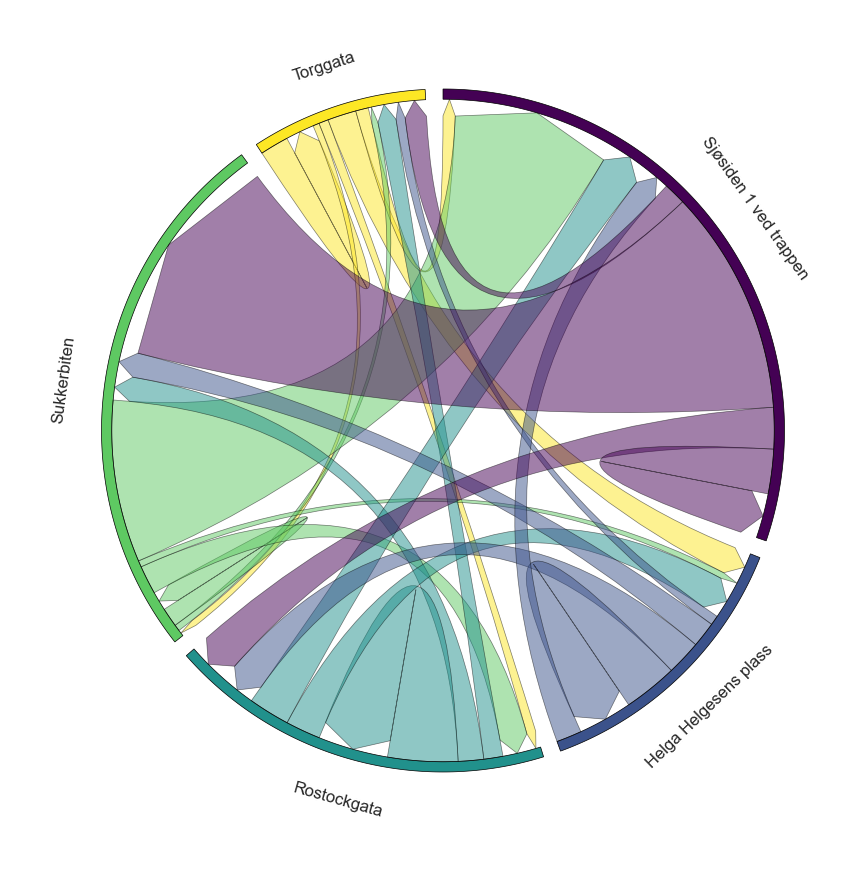

In [118]:
from pycirclize import Circos
from pycirclize.utils import calc_group_spaces, ColorCycler

# Concatenate start_station_name and end_station_name
stations = pd.concat([gdf_rides['start_station_name'], gdf_rides['end_station_name']])

# Get top 5 stations with most rides
top_stations = stations.value_counts().head(5)
filtered_gdf_rides = gdf_rides[gdf_rides['start_station_name'].isin(top_stations.index) | gdf_rides['end_station_name'].isin(top_stations.index)]

# Create from-to table dataframe & convert to matrix
from_to_table = filtered_gdf_rides.groupby(['start_station_name', 'end_station_name']).size().unstack().fillna(0)

matrix_df = pd.DataFrame(from_to_table, index=top_stations.index, columns=top_stations.index)

circos = Circos.initialize_from_matrix(
    matrix_df,
    space=3,
    cmap="viridis",
    label_kws=dict(size=12, r=110),
    link_kws=dict(direction=1, ec="black", lw=0.5),
)
fig = circos.plotfig()

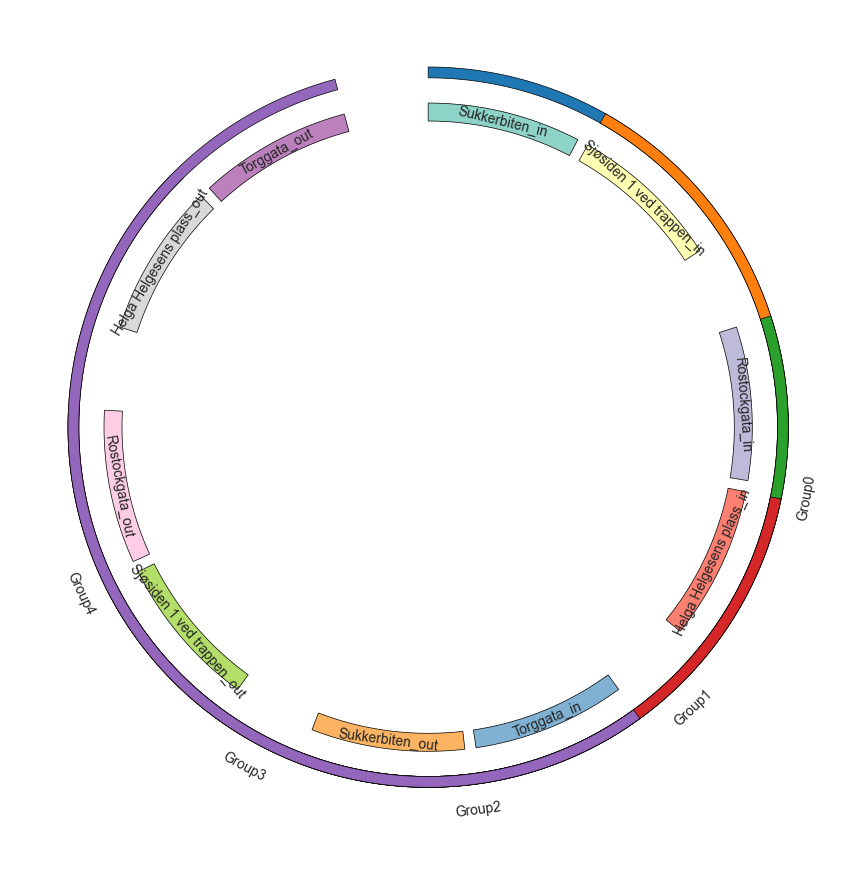

In [135]:
from pycirclize import Circos
from pycirclize.utils import calc_group_spaces, ColorCycler

# Concatenate start_station_name and end_station_name
stations = pd.concat([gdf_rides['start_station_name'], gdf_rides['end_station_name']])

# Get top 5 stations with most rides
top_stations = stations.value_counts().head(5)

# Filter the rides dataframe to only include the top 5 stations
filtered_gdf_rides = gdf_rides[gdf_rides['start_station_name'].isin(top_stations.index) & gdf_rides['end_station_name'].isin(top_stations.index)]

# Create sectors for each station
stations = filtered_gdf_rides['start_station_name'].unique()
sectors = {f"{station}_in": 10 for station in stations}
sectors.update({f"{station}_out": 10 for station in stations})

# Create groups for each station
groups = [[f"{station}_in", f"{station}_out"] for station in stations]

# Calculate appropriate group between/within spaces
spaces = calc_group_spaces([2]*5, space_bw_group=15, space_in_group=2)


circos = Circos(sectors, space=spaces)

# Plot sector track
ColorCycler.set_cmap("Set3")
for sector in circos.sectors:
    track = sector.add_track(r_lim=(85, 90))
    track.axis(fc=ColorCycler())
    track.text(sector.name)

# Plot group sectors range
ColorCycler.set_cmap("tab10")
for idx, group in enumerate(groups):
    group_deg_lim = circos.get_group_sectors_deg_lim(group)
    circos.rect(r_lim=(97, 100), deg_lim=group_deg_lim, fc=ColorCycler(), ec="black", lw=0.5)
    group_center_deg = sum(group_deg_lim) / 2
    circos.text(f"Group{idx}", r=105, deg=group_center_deg, adjust_rotation=True)

fig = circos.plotfig()

                        Sjøsiden 1 ved trappen  Helga Helgesens plass  \
Sjøsiden 1 ved trappen                      14                      0   
Helga Helgesens plass                        8                     17   
Rostockgata                                 13                     11   

                        Rostockgata  
Sjøsiden 1 ved trappen           13  
Helga Helgesens plass            11  
Rostockgata                      22  
{'Rostockgata_in': 6, 'Helga Helgesens plass_in': 6, 'Sjøsiden 1 ved trappen_in': 6, 'Rostockgata_out': 6, 'Helga Helgesens plass_out': 6, 'Sjøsiden 1 ved trappen_out': 6}


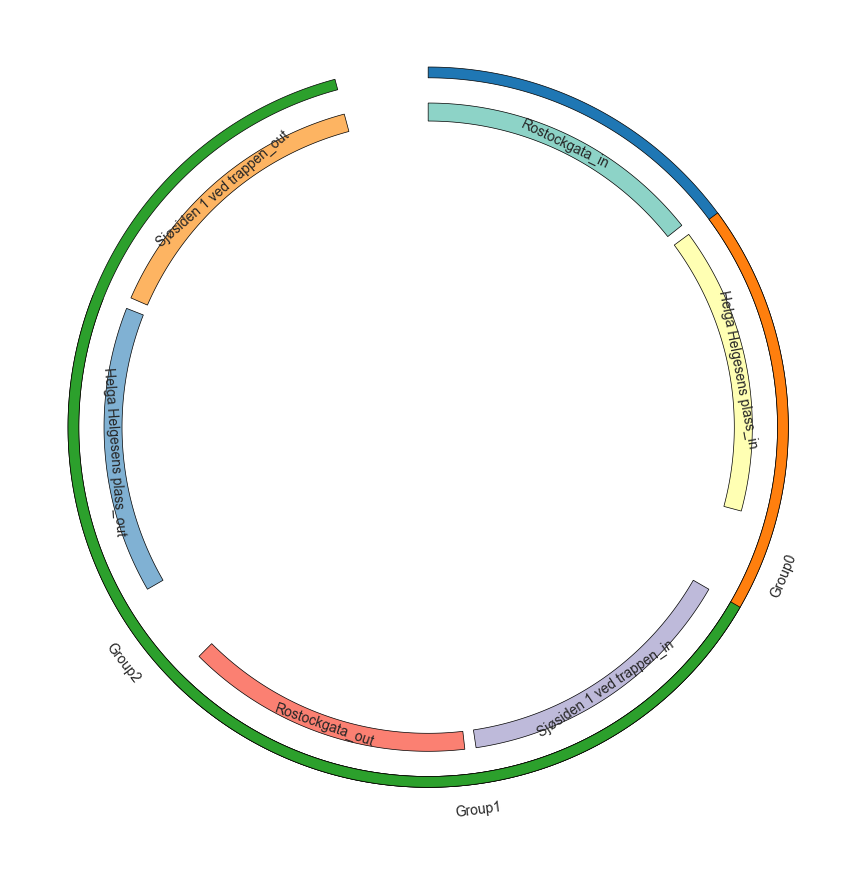

In [216]:
from pycirclize import Circos
from pycirclize.utils import calc_group_spaces, ColorCycler
import pandas as pd
import numpy as np

# Concatenate start_station_name and end_station_name
stations = pd.concat([gdf_rides['start_station_name'], gdf_rides['end_station_name']])
top_stations = stations.value_counts().head(3)
filtered_gdf_rides = gdf_rides[gdf_rides['start_station_name'].isin(top_stations.index) & gdf_rides['end_station_name'].isin(top_stations.index)]
from_to_table = filtered_gdf_rides.groupby(['start_station_name', 'end_station_name']).size().unstack().fillna(0)
matrix_df = pd.DataFrame(from_to_table, index=top_stations.index, columns=top_stations.index)
matrix_df = matrix_df.astype(int)
print(matrix_df)

# Create a matrix with random values
# matrix_df = pd.DataFrame(np.random.rand(10, 10), index=list("ABCDEFGHIJ"), columns=list("ABCDEFGHIJ"))

circos = Circos.initialize_from_matrix(
    matrix_df,
    space=3,
    cmap="viridis",
    label_kws=dict(size=12, r=110),
    link_kws=dict(direction=1, ec="black", lw=0.5),
)

stations = filtered_gdf_rides['start_station_name'].unique()
sectors = {f"{station}_in": 6 for station in stations}
sectors.update({f"{station}_out": 6 for station in stations})
print(sectors)
# Create groups for each station
groups = [[f"{station}_in", f"{station}_out"] for station in stations]

# Calculate appropriate group between/within spaces
spaces = calc_group_spaces([2, 2, 2], space_bw_group=15, space_in_group=2)

circos = Circos(sectors, space=spaces)

# Plot sector track
ColorCycler.set_cmap("Set3")
for sector in circos.sectors:
    track = sector.add_track(r_lim=(85, 90))
    track.axis(fc=ColorCycler())
    track.text(sector.name)

# Plot group sectors range
ColorCycler.set_cmap("tab10")
for idx, group in enumerate(groups):
    group_deg_lim = circos.get_group_sectors_deg_lim(group)
    circos.rect(r_lim=(97, 100), deg_lim=group_deg_lim, fc=ColorCycler(), ec="black", lw=0.5)
    group_center_deg = sum(group_deg_lim) / 2
    circos.text(f"Group{idx}", r=105, deg=group_center_deg, adjust_rotation=True)

fig = circos.plotfig()